In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

In [4]:
import BSE

# Simulation

In [90]:
def simulate(traders):
    from reinforcement_trading.simulation import start_time, end_time, order_sched, add_other_traders
    trader_stats = add_other_traders(traders)
    BSE.market_session('trial_id', start_time, end_time, traders, trader_stats,
                       order_sched, False)


In [5]:
from reinforcement_trading.simulation import market_data

In [6]:
log = market_data()
log

[TID B00 type ZIC balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIP balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type ZIP balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type SHVR balance 0.0 blotter [] orders []]
[TID B08 type SHVR balance 0.0 blotter [] orders []]
[TID B09 type SHVR balance 0.0 blotter [] orders []]
[TID B10 type ZIC balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type GVWY balance 0.0 blotter [] orders []]
[TID B13 type ZIC balance 0.0 blotter [] orders []]
[TID B14 type ZIP balance 0.0 blotter [] orders []]
[TID B15 type ZIP balance 0.0 blotter [] orders []]
[TID S00 type GVWY balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIC balance 0.0 blotter [] orders []]
[TI

[(1.181818181818181,
  {'asks': {'best': 1000, 'lob': [[1000, 1]], 'n': 1, 'worst': 1000},
   'bids': {'best': None, 'lob': [], 'n': 0, 'worst': 1},
   'time': 1.181818181818181},
  None),
 (1.6060606060606049,
  {'asks': {'best': 123, 'lob': [[123, 1], [1000, 1]], 'n': 2, 'worst': 1000},
   'bids': {'best': None, 'lob': [], 'n': 0, 'worst': 1},
   'time': 1.6060606060606049},
  None),
 (2.7575757575757556,
  {'asks': {'best': 122, 'lob': [[122, 1], [123, 1]], 'n': 2, 'worst': 1000},
   'bids': {'best': None, 'lob': [], 'n': 0, 'worst': 1},
   'time': 2.7575757575757556},
  None),
 (3.121212121212119,
  {'asks': {'best': 122,
    'lob': [[122, 1], [123, 1], [901, 1]],
    'n': 3,
    'worst': 1000},
   'bids': {'best': None, 'lob': [], 'n': 0, 'worst': 1},
   'time': 3.121212121212119},
  None),
 (3.24242424242424,
  {'asks': {'best': 122,
    'lob': [[122, 1], [298, 1], [901, 1]],
    'n': 3,
    'worst': 1000},
   'bids': {'best': None, 'lob': [], 'n': 0, 'worst': 1},
   'time': 3.24

In [98]:
[foo for foo in log if foo[2] is not None]

[(5.36363636363636,
  {'asks': {'best': 503, 'lob': [[503, 1]], 'n': 1, 'worst': 1000},
   'bids': {'best': 105, 'lob': [[1, 1], [105, 1]], 'n': 2, 'worst': 1},
   'time': 5.36363636363636},
  {'party1': 'B14',
   'party2': 'S07',
   'price': 105,
   'qty': 1,
   'time': 5.36363636363636}),
 (6.030303030303026,
  {'asks': {'best': 829, 'lob': [[829, 1]], 'n': 1, 'worst': 1000},
   'bids': {'best': 105, 'lob': [[105, 1]], 'n': 1, 'worst': 1},
   'time': 6.030303030303026},
  {'party1': 'B15',
   'party2': 'S01',
   'price': 105,
   'qty': 1,
   'time': 6.030303030303026}),
 (20.63636363636399,
  {'asks': {'best': 108,
    'lob': [[108, 1], [117, 1], [118, 1], [187, 1], [609, 1], [793, 1]],
    'n': 6,
    'worst': 1000},
   'bids': {'best': 106,
    'lob': [[27, 1], [74, 1], [75, 1], [96, 1], [97, 1], [105, 1], [106, 2]],
    'n': 8,
    'worst': 1},
   'time': 20.63636363636399},
  {'party1': 'B11',
   'party2': 'S13',
   'price': 106,
   'qty': 1,
   'time': 20.63636363636399}),
 (21.

In [7]:
prices = pd.DataFrame({'time': [foo[0] for foo in log],
                       'bid': [foo[1]['bids']['best'] for foo in log],
                       'ask': [foo[1]['asks']['best'] for foo in log]})

In [8]:
trades = pd.DataFrame({'time': [foo[0] for foo in log if foo[2] is not None],
                       'price': [foo[2]['price'] for foo in log if foo[2] is not None],
                       'qty': [foo[2]['qty'] for foo in log if foo[2] is not None]})

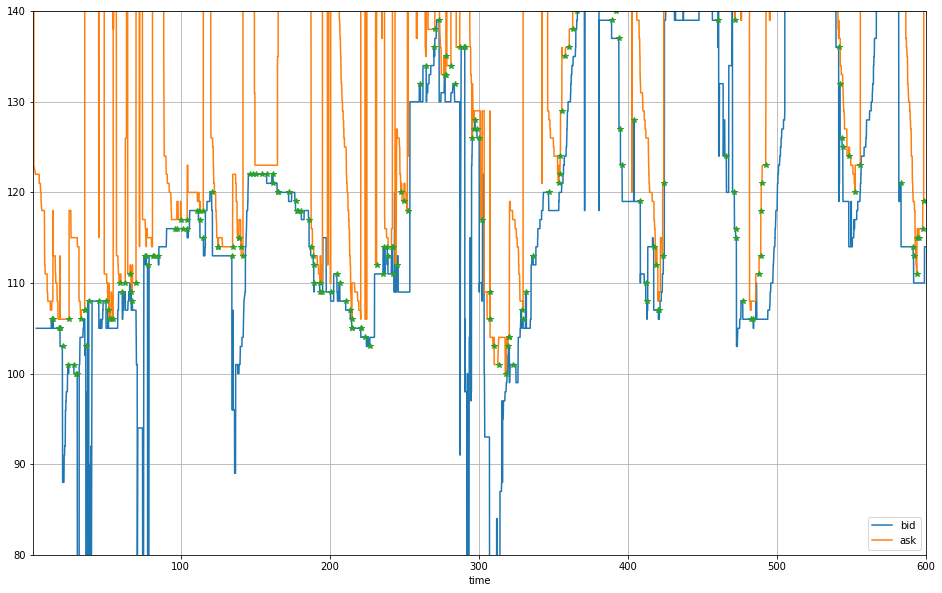

In [9]:
prices.plot(x='time', y=['bid', 'ask'], figsize=(16, 10))
plt.plot(trades['time'], trades['price'], '*', label='trades')
plt.ylim([80, 140])
plt.grid()

# Features

In [24]:
class Feature(object):
    def update(self, time, lob, trade):
        raise LogicError("Abstract class method")

### Sampling

In [13]:
def replay(log, traders, verbose=False):
    for time, lob, trade in log:
        for trader in traders:
            trader.respond(time, lob, trade, verbose)

In [14]:
class Sampler(BSE.Trader):
    def __init__(self, tid, features):
        super(Sampler, self).__init__('Sampler', tid, 0)
        self.features = [feature() for name, feature in features]
        self.names = [name for name, feature in features]
        self.log = []
        self.times = []
        
    def respond(self, time, lob, trade, verbose):
        res = np.empty(len(self.features))
        for i, feature in enumerate(self.features):
            try:
                res[i] = feature.update(time, lob, trade)
            except:
                res[i] = np.nan
        self.log.append(res)
        self.times.append(time)
            
    def getorder(self, time, time_left, lob):
        return None
    
    def get(self):
        return pd.DataFrame(self.log, index=self.times, columns=self.names)


In [15]:
def sample(log, features):
    sampler = Sampler('sampler', features)
    replay(log, [sampler])
    return sampler.get()

### Features

In [29]:
class Bid(Feature):
    def update(self, time, lob, trade):
        if lob['bids']['best'] is not None:
            return lob['bids']['best']
        else:
            return lob['bids']['worst']
        
def bid(name='bid'):
    return (name, Bid)

In [30]:
class Ask(Feature):
    def update(self, time, lob, trade):
        if lob['asks']['best'] is not None:
            return lob['asks']['best']
        else:
            return lob['asks']['worst']

def ask(name='ask'):
    return (name, Ask)

#### Combinations

In [61]:
class Difference(Feature):
    def __init__(self, a, b):
        self.a = a()
        self.b = b()
        
    def update(self, time, lob, trade):
        return self.a.update(time, lob, trade) - self.b.update(time, lob, trade)
    
def difference(a, b, name=None):
    if name is None:
        name = '({} - {})'.format(a[0], b[0])
    return (name, lambda: Difference(a[1], b[1]))

In [62]:
class Sum(Feature):
    def __init__(self, a, b):
        self.a = a()
        self.b = b()
        
    def update(self, time, lob, trade):
        return self.a.update(time, lob, trade) + self.b.update(time, lob, trade)
    
def sum_feature(a, b, name=None):
    if name is None:
        name = '({} + {})'.format(a[0], b[0])
    return (name, lambda: Sum(a[1], b[1]))

In [142]:
class Product(Feature):
    def __init__(self, a, b):
        self.a = a()
        self.b = b()
        
    def update(self, time, lob, trade):
        return self.a.update(time, lob, trade) * self.b.update(time, lob, trade)
    
def product(a, b, name=None):
    if name is None:
        name = '({} * {})'.format(a[0], b[0])
    return (name, lambda: Product(a[1], b[1]))

In [143]:
class Quotient(Feature):
    def __init__(self, a, b):
        self.a = a()
        self.b = b()
        
    def update(self, time, lob, trade):
        return self.a.update(time, lob, trade) / self.b.update(time, lob, trade)
    
def quotient(a, b, name=None):
    if name is None:
        name = '({} / {})'.format(a[0], b[0])
    return (name, lambda: Quotient(a[1], b[1]))

In [65]:
class Constant(Feature):
    def __init__(self, value):
        self.value = value
        
    def update(self, time, lob, trade):
        return self.value
    
def constant(value, name=None):
    if name is None:
        name = '{}'.format(value)
    return (name, lambda: Constant(value))

#### Book price

In [37]:
def book_price_value(qty, bids, asks):
    def impl(lob, sign):
        tot_price = 0
        tot_size = 0
        level = 0 if sign > 0 else len(lob) - 1
        while tot_size < qty and level >= 0 and level < len(lob):
            lv_price = lob[level][0]
            lv_size = lob[level][1]
            eff_size = lv_size if lv_size < qty - tot_size else qty - tot_size
            tot_price += eff_size * lv_price
            tot_size += eff_size
            level += sign
        if tot_size == qty:
            return tot_price / tot_size
        else:
            return None
    bp = impl(bids, -1)
    ap = impl(asks, 1)
    if bp is None or ap is None:
        return None
    else:
        return 0.5 * (bp + ap)

class BookPrice(Feature):
    def __init__(self, qty):
        self.qty = qty
        
    def update(self, time, lob, trade):
        res = book_price_value(self.qty, lob['bids']['lob'], lob['asks']['lob'])
        return res if res is not None else np.nan
    
def book_price(qty, name=None):
    if name is None:
        name = 'book_price({})'.format(qty)
    return (name, lambda: BookPrice(qty))

#### EMA

In [40]:
def ema_series(series, dur, reset_on_nan=False):
    def gen():
        last = np.nan
        last_t = np.nan
        last_v = np.nan
        for t, v in zip(series.index, series):
            # Decay towards last_v
            if np.isfinite(last_v):
                # last must also be finite
                k = np.exp((last_t - t) / dur)
                last = last * k + last_v * (1 - k)
            # Process NaNs
            if not np.isfinite(v) and reset_on_nan:
                last = v
            if not np.isfinite(last) and np.isfinite(v):
                last = v
            # Remember state
            last_v = v
            last_t = t
            yield last
    return pd.Series(gen(), index=series.index)

In [50]:
class EMA(Feature):
    def __init__(self, base, duration, reset_on_nan=False):
        self.base = base()
        self.dur = duration
        self.reset_on_nan = reset_on_nan
        self.last = np.nan
        self.last_t = np.nan
        self.last_v = np.nan

        
    def update(self, time, lob, trade):
        v = self.base.update(time, lob, trade)
        # Decay towards last_v
        if np.isfinite(self.last_v):
            # last must also be finite
            k = np.exp((self.last_t - time) / self.dur)
            self.last = self.last * k + self.last_v * (1 - k)
        # Process NaNs
        if not np.isfinite(v) and self.reset_on_nan:
            self.last = v
        if not np.isfinite(self.last) and np.isfinite(v):
            self.last = v
        # Remember state
        self.last_v = v
        self.last_t = time
        return self.last
    
def ema(base, duration, reset_on_nan=False, name=None):
    if name is None:
        name = 'ema({})'.format(base[0])
    return (name, lambda: EMA(base[1], duration, reset_on_nan))

### Testing

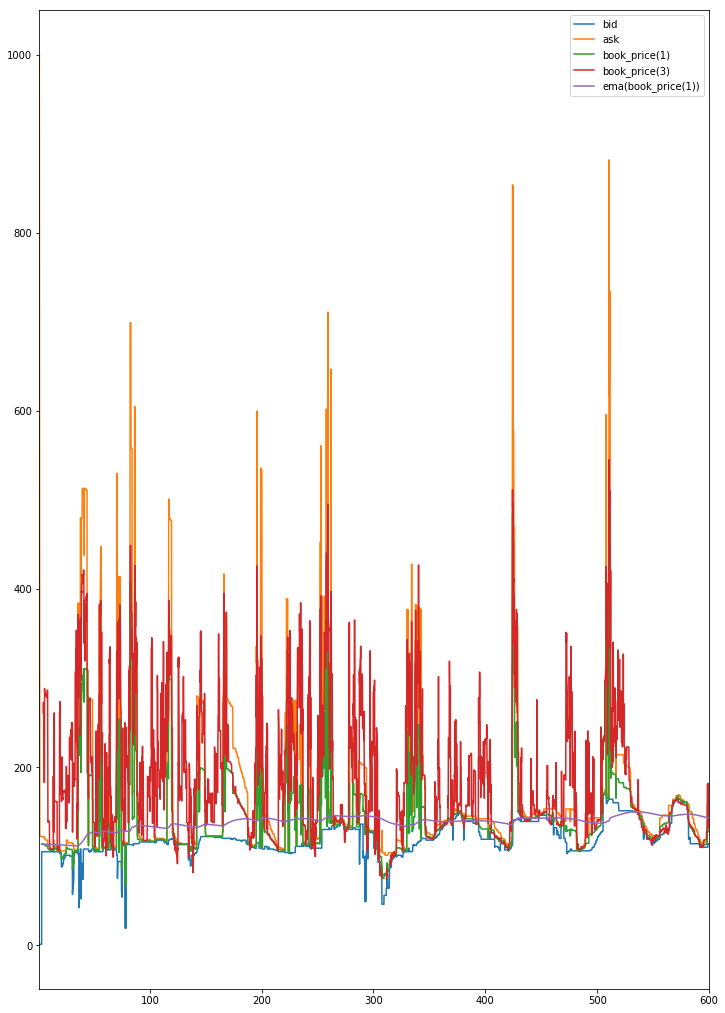

In [51]:
sample(log, [bid(), ask(), book_price(1), book_price(3), ema(book_price(1), 100)]).plot(figsize=(12, 18))

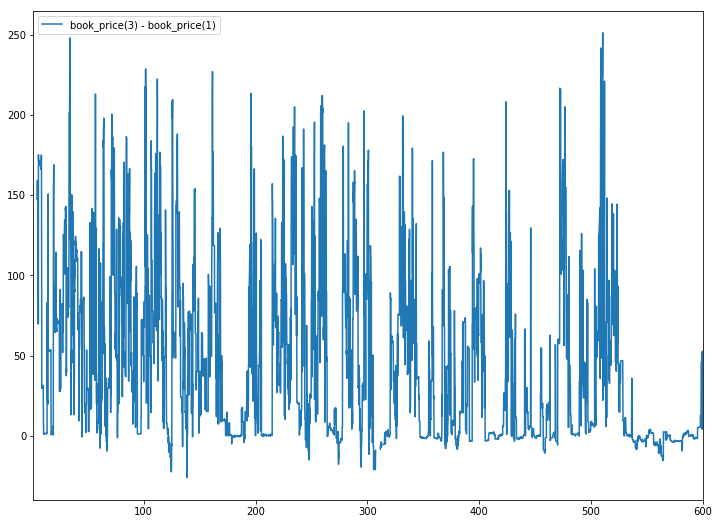

In [60]:
sample(log, [difference(book_price(3), book_price(1))]).plot(figsize=(12, 9))

### Future Return

In [69]:
def future_value(mid, horizon):
    res = mid.reindex(mid.index + horizon, method='pad')
    res.index = mid.index
    return res

In [70]:
def future_return(mid, horizon):
    return mid.reindex(mid.index + horizon, method='pad').values - mid

In [71]:
def conservative_future_return(bid, ask, horizon):
    pos_part = future_value(bid, horizon) - ask
    pos_part = pos_part.where(pos_part > 0, other=0.0)
    neg_part = future_value(ask, horizon) - bid
    neg_part = neg_part.where(neg_part < 0, other=0.0)
    return pos_part + neg_part

In [121]:
conservative_future_return(pd.Series(np.arange(12)), pd.Series(np.arange(1, 13)), 3)

0     2.0
1     2.0
2     2.0
3     2.0
4     2.0
5     2.0
6     2.0
7     2.0
8     2.0
9     1.0
10    0.0
11    0.0
dtype: float64

### Is book_price predictive of future return?

In [66]:
logs = [market_data() for i in range(100)]

[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type GVWY balance 0.0 blotter [] orders []]
[TID B06 type ZIC balance 0.0 blotter [] orders []]
[TID B07 type ZIC balance 0.0 blotter [] orders []]
[TID B08 type SHVR balance 0.0 blotter [] orders []]
[TID B09 type ZIP balance 0.0 blotter [] orders []]
[TID B10 type ZIP balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type GVWY balance 0.0 blotter [] orders []]
[TID B13 type GVWY balance 0.0 blotter [] orders []]
[TID B14 type SHVR balance 0.0 blotter [] orders []]
[TID B15 type SHVR balance 0.0 blotter [] orders []]
[TID S00 type ZIP balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIP balance 0.0 blotter [] orders []]
[TID

[TID B00 type SHVR balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type GVWY balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type ZIC balance 0.0 blotter [] orders []]
[TID B05 type ZIP balance 0.0 blotter [] orders []]
[TID B06 type SHVR balance 0.0 blotter [] orders []]
[TID B07 type ZIC balance 0.0 blotter [] orders []]
[TID B08 type GVWY balance 0.0 blotter [] orders []]
[TID B09 type GVWY balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type ZIC balance 0.0 blotter [] orders []]
[TID B15 type SHVR balance 0.0 blotter [] orders []]
[TID S00 type SHVR balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIP balance 0.0 blotter [] orders []]
[TI

[TID S09 type SHVR balance 0.0 blotter [] orders []]
[TID S10 type ZIC balance 0.0 blotter [] orders []]
[TID S11 type GVWY balance 0.0 blotter [] orders []]
[TID S12 type GVWY balance 0.0 blotter [] orders []]
[TID S13 type ZIC balance 0.0 blotter [] orders []]
[TID S14 type ZIC balance 0.0 blotter [] orders []]
[TID S15 type ZIP balance 0.0 blotter [] orders []]
[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type ZIC balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type ZIP balance 0.0 blotter [] orders []]
[TID B07 type SHVR balance 0.0 blotter [] orders []]
[TID B08 type GVWY balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type GVWY balance 0.0 blotter [] orders []]
[TID B11 type ZIP balance 0.0 blotter [] orders []]
[TID

[TID S07 type ZIP balance 0.0 blotter [] orders []]
[TID S08 type SHVR balance 0.0 blotter [] orders []]
[TID S09 type ZIP balance 0.0 blotter [] orders []]
[TID S10 type GVWY balance 0.0 blotter [] orders []]
[TID S11 type ZIP balance 0.0 blotter [] orders []]
[TID S12 type ZIC balance 0.0 blotter [] orders []]
[TID S13 type ZIC balance 0.0 blotter [] orders []]
[TID S14 type ZIP balance 0.0 blotter [] orders []]
[TID S15 type ZIC balance 0.0 blotter [] orders []]
[TID B00 type ZIC balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type GVWY balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type GVWY balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type SHVR balance 0.0 blotter [] orders []]
[TID B09 type ZIP balance 0.0 blotter [] orders []]
[TID 

[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type GVWY balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type ZIC balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type GVWY balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type ZIC balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type SHVR balance 0.0 blotter [] orders []]
[TID B14 type ZIC balance 0.0 blotter [] orders []]
[TID B15 type SHVR balance 0.0 blotter [] orders []]
[TID S00 type ZIC balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIP balance 0.0 blotter [] orders []]
[TID

[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type SHVR balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type ZIC balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type GVWY balance 0.0 blotter [] orders []]
[TID B09 type GVWY balance 0.0 blotter [] orders []]
[TID B10 type ZIC balance 0.0 blotter [] orders []]
[TID B11 type ZIP balance 0.0 blotter [] orders []]
[TID B12 type SHVR balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type GVWY balance 0.0 blotter [] orders []]
[TID B15 type ZIC balance 0.0 blotter [] orders []]
[TID S00 type GVWY balance 0.0 blotter [] orders []]
[TID S01 type GVWY balance 0.0 blotter [] orders []]
[TID S02 type GVWY balance 0.0 blotter [] orders []]
[

[TID S14 type SHVR balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type SHVR balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type SHVR balance 0.0 blotter [] orders []]
[TID B04 type GVWY balance 0.0 blotter [] orders []]
[TID B05 type ZIP balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type SHVR balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type ZIC balance 0.0 blotter [] orders []]
[TID B12 type GVWY balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type ZIP balance 0.0 blotter [] orders []]
[TID B15 type GVWY balance 0.0 blotter [] orders []]
[TID S00 type SHVR balance 0.0 blotter [] orders []]
[

[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIP balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type ZIC balance 0.0 blotter [] orders []]
[TID B06 type ZIP balance 0.0 blotter [] orders []]
[TID B07 type GVWY balance 0.0 blotter [] orders []]
[TID B08 type GVWY balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type SHVR balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type SHVR balance 0.0 blotter [] orders []]
[TID B14 type ZIC balance 0.0 blotter [] orders []]
[TID B15 type GVWY balance 0.0 blotter [] orders []]
[TID S00 type SHVR balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIC balance 0.0 blotter [] orders []]
[TI

[TID S06 type SHVR balance 0.0 blotter [] orders []]
[TID S07 type ZIC balance 0.0 blotter [] orders []]
[TID S08 type ZIC balance 0.0 blotter [] orders []]
[TID S09 type SHVR balance 0.0 blotter [] orders []]
[TID S10 type GVWY balance 0.0 blotter [] orders []]
[TID S11 type SHVR balance 0.0 blotter [] orders []]
[TID S12 type ZIP balance 0.0 blotter [] orders []]
[TID S13 type ZIC balance 0.0 blotter [] orders []]
[TID S14 type GVWY balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type SHVR balance 0.0 blotter [] orders []]
[TID B02 type ZIP balance 0.0 blotter [] orders []]
[TID B03 type ZIC balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type ZIC balance 0.0 blotter [] orders []]
[TID B06 type ZIP balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type ZIC balance 0.0 blotter [] orders []]
[TI

[TID S03 type SHVR balance 0.0 blotter [] orders []]
[TID S04 type GVWY balance 0.0 blotter [] orders []]
[TID S05 type SHVR balance 0.0 blotter [] orders []]
[TID S06 type ZIC balance 0.0 blotter [] orders []]
[TID S07 type ZIC balance 0.0 blotter [] orders []]
[TID S08 type ZIP balance 0.0 blotter [] orders []]
[TID S09 type GVWY balance 0.0 blotter [] orders []]
[TID S10 type ZIC balance 0.0 blotter [] orders []]
[TID S11 type SHVR balance 0.0 blotter [] orders []]
[TID S12 type ZIP balance 0.0 blotter [] orders []]
[TID S13 type ZIP balance 0.0 blotter [] orders []]
[TID S14 type ZIC balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type ZIP balance 0.0 blotter [] orders []]
[TID

[TID S13 type ZIP balance 0.0 blotter [] orders []]
[TID S14 type ZIC balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIP balance 0.0 blotter [] orders []]
[TID B02 type SHVR balance 0.0 blotter [] orders []]
[TID B03 type SHVR balance 0.0 blotter [] orders []]
[TID B04 type ZIP balance 0.0 blotter [] orders []]
[TID B05 type GVWY balance 0.0 blotter [] orders []]
[TID B06 type ZIC balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type GVWY balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type ZIC balance 0.0 blotter [] orders []]
[TID B13 type ZIC balance 0.0 blotter [] orders []]
[TID B14 type SHVR balance 0.0 blotter [] orders []]
[TID B15 type GVWY balance 0.0 blotter [] orders []]
[TI

[TID S08 type ZIC balance 0.0 blotter [] orders []]
[TID S09 type GVWY balance 0.0 blotter [] orders []]
[TID S10 type ZIC balance 0.0 blotter [] orders []]
[TID S11 type SHVR balance 0.0 blotter [] orders []]
[TID S12 type SHVR balance 0.0 blotter [] orders []]
[TID S13 type ZIC balance 0.0 blotter [] orders []]
[TID S14 type ZIP balance 0.0 blotter [] orders []]
[TID S15 type ZIP balance 0.0 blotter [] orders []]
[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type GVWY balance 0.0 blotter [] orders []]
[TID B02 type ZIP balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type ZIC balance 0.0 blotter [] orders []]
[TID B06 type SHVR balance 0.0 blotter [] orders []]
[TID B07 type GVWY balance 0.0 blotter [] orders []]
[TID B08 type SHVR balance 0.0 blotter [] orders []]
[TID B09 type SHVR balance 0.0 blotter [] orders []]
[TID B10 type ZIC balance 0.0 blotter [] orders []]
[TI

[TID S11 type ZIC balance 0.0 blotter [] orders []]
[TID S12 type ZIC balance 0.0 blotter [] orders []]
[TID S13 type ZIP balance 0.0 blotter [] orders []]
[TID S14 type ZIP balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type ZIC balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type SHVR balance 0.0 blotter [] orders []]
[TID B07 type ZIP balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type SHVR balance 0.0 blotter [] orders []]
[TID B12 type GVWY balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID

[TID B00 type SHVR balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type SHVR balance 0.0 blotter [] orders []]
[TID B05 type GVWY balance 0.0 blotter [] orders []]
[TID B06 type ZIC balance 0.0 blotter [] orders []]
[TID B07 type GVWY balance 0.0 blotter [] orders []]
[TID B08 type SHVR balance 0.0 blotter [] orders []]
[TID B09 type ZIP balance 0.0 blotter [] orders []]
[TID B10 type ZIP balance 0.0 blotter [] orders []]
[TID B11 type ZIP balance 0.0 blotter [] orders []]
[TID B12 type ZIC balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type GVWY balance 0.0 blotter [] orders []]
[TID B15 type SHVR balance 0.0 blotter [] orders []]
[TID S00 type ZIC balance 0.0 blotter [] orders []]
[TID S01 type GVWY balance 0.0 blotter [] orders []]
[TID S02 type ZIP balance 0.0 blotter [] orders []]
[TI

[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type ZIC balance 0.0 blotter [] orders []]
[TID B02 type GVWY balance 0.0 blotter [] orders []]
[TID B03 type SHVR balance 0.0 blotter [] orders []]
[TID B04 type ZIP balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type SHVR balance 0.0 blotter [] orders []]
[TID B07 type GVWY balance 0.0 blotter [] orders []]
[TID B08 type ZIC balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type GVWY balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type SHVR balance 0.0 blotter [] orders []]
[TID B15 type ZIC balance 0.0 blotter [] orders []]
[TID S00 type SHVR balance 0.0 blotter [] orders []]
[TID S01 type GVWY balance 0.0 blotter [] orders []]
[TID S02 type SHVR balance 0.0 blotter [] orders []]
[

[TID S09 type SHVR balance 0.0 blotter [] orders []]
[TID S10 type GVWY balance 0.0 blotter [] orders []]
[TID S11 type ZIC balance 0.0 blotter [] orders []]
[TID S12 type ZIC balance 0.0 blotter [] orders []]
[TID S13 type ZIP balance 0.0 blotter [] orders []]
[TID S14 type ZIP balance 0.0 blotter [] orders []]
[TID S15 type GVWY balance 0.0 blotter [] orders []]
[TID B00 type ZIP balance 0.0 blotter [] orders []]
[TID B01 type GVWY balance 0.0 blotter [] orders []]
[TID B02 type SHVR balance 0.0 blotter [] orders []]
[TID B03 type SHVR balance 0.0 blotter [] orders []]
[TID B04 type GVWY balance 0.0 blotter [] orders []]
[TID B05 type ZIC balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type ZIC balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type SHVR balance 0.0 blotter [] orders []]
[TID B11 type ZIC balance 0.0 blotter [] orders []]
[TI

[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type SHVR balance 0.0 blotter [] orders []]
[TID B02 type SHVR balance 0.0 blotter [] orders []]
[TID B03 type ZIC balance 0.0 blotter [] orders []]
[TID B04 type GVWY balance 0.0 blotter [] orders []]
[TID B05 type ZIP balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type ZIC balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type SHVR balance 0.0 blotter [] orders []]
[TID B10 type ZIC balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type SHVR balance 0.0 blotter [] orders []]
[TID B14 type ZIC balance 0.0 blotter [] orders []]
[TID B15 type ZIP balance 0.0 blotter [] orders []]
[TID S00 type GVWY balance 0.0 blotter [] orders []]
[TID S01 type SHVR balance 0.0 blotter [] orders []]
[TID S02 type GVWY balance 0.0 blotter [] orders []]
[

[TID B00 type GVWY balance 0.0 blotter [] orders []]
[TID B01 type SHVR balance 0.0 blotter [] orders []]
[TID B02 type SHVR balance 0.0 blotter [] orders []]
[TID B03 type ZIP balance 0.0 blotter [] orders []]
[TID B04 type GVWY balance 0.0 blotter [] orders []]
[TID B05 type ZIC balance 0.0 blotter [] orders []]
[TID B06 type ZIC balance 0.0 blotter [] orders []]
[TID B07 type ZIC balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type SHVR balance 0.0 blotter [] orders []]
[TID B10 type ZIC balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type SHVR balance 0.0 blotter [] orders []]
[TID B13 type ZIP balance 0.0 blotter [] orders []]
[TID B14 type ZIP balance 0.0 blotter [] orders []]
[TID B15 type GVWY balance 0.0 blotter [] orders []]
[TID S00 type ZIP balance 0.0 blotter [] orders []]
[TID S01 type SHVR balance 0.0 blotter [] orders []]
[TID S02 type ZIC balance 0.0 blotter [] orders []]
[TI

[TID S02 type GVWY balance 0.0 blotter [] orders []]
[TID S03 type ZIP balance 0.0 blotter [] orders []]
[TID S04 type ZIP balance 0.0 blotter [] orders []]
[TID S05 type ZIC balance 0.0 blotter [] orders []]
[TID S06 type ZIC balance 0.0 blotter [] orders []]
[TID S07 type ZIC balance 0.0 blotter [] orders []]
[TID S08 type SHVR balance 0.0 blotter [] orders []]
[TID S09 type ZIC balance 0.0 blotter [] orders []]
[TID S10 type GVWY balance 0.0 blotter [] orders []]
[TID S11 type SHVR balance 0.0 blotter [] orders []]
[TID S12 type GVWY balance 0.0 blotter [] orders []]
[TID S13 type ZIP balance 0.0 blotter [] orders []]
[TID S14 type GVWY balance 0.0 blotter [] orders []]
[TID S15 type SHVR balance 0.0 blotter [] orders []]
[TID B00 type SHVR balance 0.0 blotter [] orders []]
[TID B01 type SHVR balance 0.0 blotter [] orders []]
[TID B02 type ZIC balance 0.0 blotter [] orders []]
[TID B03 type GVWY balance 0.0 blotter [] orders []]
[TID B04 type ZIP balance 0.0 blotter [] orders []]
[T

[TID S06 type ZIC balance 0.0 blotter [] orders []]
[TID S07 type ZIC balance 0.0 blotter [] orders []]
[TID S08 type ZIC balance 0.0 blotter [] orders []]
[TID S09 type SHVR balance 0.0 blotter [] orders []]
[TID S10 type SHVR balance 0.0 blotter [] orders []]
[TID S11 type SHVR balance 0.0 blotter [] orders []]
[TID S12 type ZIP balance 0.0 blotter [] orders []]
[TID S13 type GVWY balance 0.0 blotter [] orders []]
[TID S14 type GVWY balance 0.0 blotter [] orders []]
[TID S15 type ZIP balance 0.0 blotter [] orders []]


In [67]:
from reinforcement_trading.tools import indexed_concat

In [131]:
feature = indexed_concat([make_book_price(foo, 3) - make_book_price(foo, 1) for foo in logs])
response = indexed_concat([future_return(make_book_price(foo, 1), 30) for foo in logs])

In [72]:
feature = indexed_concat([sample(foo, [difference(book_price(3), book_price(1))]).iloc[:, 0] for foo in logs])
response = indexed_concat([future_return(sample(foo, [book_price(1, name='mid')])['mid'], 30) for foo in logs])

In [79]:
feature.describe()

count    680241.000000
mean         34.022868
std          50.519743
min         -45.000000
25%          -0.166667
50%           8.333333
75%          57.500000
max         286.833333
Name: (book_price(3) - book_price(1)), dtype: float64

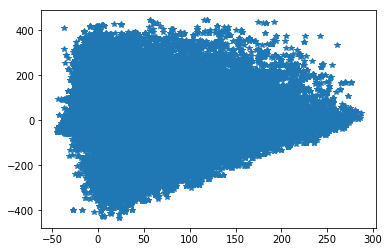

In [80]:
plt.plot(feature, response, '*')

In [75]:
def cumplot(value, order):
    if hasattr(value, 'values'):
        value = value.values
    if hasattr(order, 'values'):
        order = order.values
    inds = np.argsort(order)
    step = 1 if len(inds) < 2000 else len(inds) // 1000
    plt.plot(order[inds][::step], np.cumsum(np.nan_to_num(value[inds]))[::step])

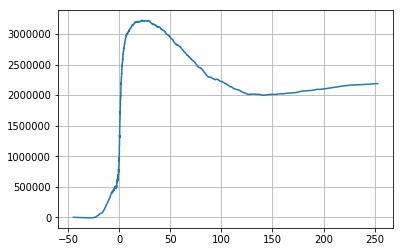

In [81]:
cumplot(response, feature)
plt.grid()

In [154]:
feature = indexed_concat([sample(foo, [difference(book_price(3), book_price(1))]).iloc[:, 0] for foo in logs])
def foo_cfr(log, horizon):
    bidask = sample(log, [bid(), ask()])
    return conservative_future_return(bidask['bid'], bidask['ask'], horizon)
response = indexed_concat([foo_cfr(foo, 60) for foo in logs])

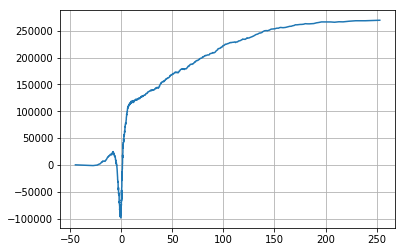

In [155]:
cumplot(response, feature)
plt.grid()

Now, this makes sense!

# Trader

In [117]:
class HFTrader(BSE.Trader):
    def __init__(self, ttype, tid, balance):
        super(HFTrader, self).__init__(ttype, tid, balance)
        self.position = 0
        self.cash = 0
    
    def bookkeep(self, trade, order, verbose):

        outstr = '%s (%s) bookkeeping: orders=' % (self.tid, self.ttype)
        for o in self.orders: outstr = outstr + str(o)

        self.blotter.append(trade)  # add trade record to trader's blotter
        # NB What follows is **LAZY** -- assumes all orders are quantity=1
        transactionprice = trade['price']
        role = 'trader' if order.tid == self.tid else 'counterparty'
        otype = order.otype if role == 'trader' else reverse_type[order.otype]
        if otype == 'Bid':
            self.cash -= transactionprice * trade['qty']
            self.position += trade['qty']
        else:
            self.cash += transactionprice * trade['qty']
            self.position -= trade['qty']
        if self.position == 0:
            self.balance = self.cash
        #if verbose: print('%s profit=%d balance=%d ' % (outstr, profit, self.balance))
        #self.del_order(order)  # delete the order


In [118]:
class FairPriceTrader(HFTrader):
    def __init__(self, tid, price_feature, time_to_exit):
        super(FairPriceTrader, self).__init__('FairPriceTrader', tid, 0)
        self.price_feature = price_feature()
        self.time_to_exit = time_to_exit
        
    def respond(self, time, lob, trade, verbose):
        self.fair_price = self.price_feature.update(time, lob, trade)
        
    def buy(self, lob):
        price = lob['asks']['best']
        if price is not None:
            order = BSE.Order(self.tid, 'Bid', price, 1, lob['time'])
            print("Buy at {}".format(price))
            return order
        
    def sell(self, lob):
        price = lob['bids']['best']
        if price is not None:
            order = BSE.Order(self.tid, 'Ask', price, 1, lob['time'])
            print("Sell at {}".format(price))
            return order
        
    def getorder(self, time, time_left, lob):
        order = None
        #print((lob['bids']['best'], lob['asks']['best'], self.fair_price))
        if time_left <= self.time_to_exit:
            if self.position > 0:
                order = self.sell(lob)
            elif self.position < 0:
                order = self.buy(lob)
        else:
            if lob['asks']['best'] is not None and lob['asks']['best'] < self.fair_price:
                if self.position < 1:
                    order = self.buy(lob)
            elif lob['bids']['best'] is not None and lob['bids']['best'] > self.fair_price:
                if self.position > -1:
                    order = self.sell(lob)
        return order


In [151]:
trader = FairPriceTrader('FPT_BP3',
                         difference(product(book_price(3), constant(7)),
                                    product(book_price(1), constant(6)))[1],
                         1.0 / 60)
simulate({trader.tid: trader})
(trader.position, trader.cash)

[TID B00 type ZIC balance 0.0 blotter [] orders []]
[TID B01 type SHVR balance 0.0 blotter [] orders []]
[TID B02 type GVWY balance 0.0 blotter [] orders []]
[TID B03 type ZIC balance 0.0 blotter [] orders []]
[TID B04 type ZIP balance 0.0 blotter [] orders []]
[TID B05 type SHVR balance 0.0 blotter [] orders []]
[TID B06 type GVWY balance 0.0 blotter [] orders []]
[TID B07 type SHVR balance 0.0 blotter [] orders []]
[TID B08 type ZIP balance 0.0 blotter [] orders []]
[TID B09 type ZIC balance 0.0 blotter [] orders []]
[TID B10 type GVWY balance 0.0 blotter [] orders []]
[TID B11 type GVWY balance 0.0 blotter [] orders []]
[TID B12 type ZIP balance 0.0 blotter [] orders []]
[TID B13 type ZIC balance 0.0 blotter [] orders []]
[TID B14 type SHVR balance 0.0 blotter [] orders []]
[TID B15 type ZIP balance 0.0 blotter [] orders []]
[TID S00 type ZIC balance 0.0 blotter [] orders []]
[TID S01 type ZIC balance 0.0 blotter [] orders []]
[TID S02 type ZIP balance 0.0 blotter [] orders []]
[TID

(0, -671)

In [93]:
trader.cash

0